In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Mounted at /content/drive/
/content/drive/MyDrive/Projects/ai_for_medicine


In [2]:
# !unzip Data/pneumonia_classification/Processed.zip -d Data/pneumonia_classification/


In [5]:
import os
print("val 0:",len(os.listdir("Data/pneumonia_classification/Processed/val/0")),
      "val 1:",len(os.listdir("Data/pneumonia_classification/Processed/val/1")),
      "train 0:",len(os.listdir("Data/pneumonia_classification/Processed/train/0")),
      "train 1:",len(os.listdir("Data/pneumonia_classification/Processed/train/1"))
)

val 0: 2079 val 1: 605 train 0: 18595 train 1: 5407


In [6]:
import torch
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.6, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [9]:
train_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/train", loader = load_file, extensions="npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/val", loader = load_file, extensions="npy", transform = val_transforms)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


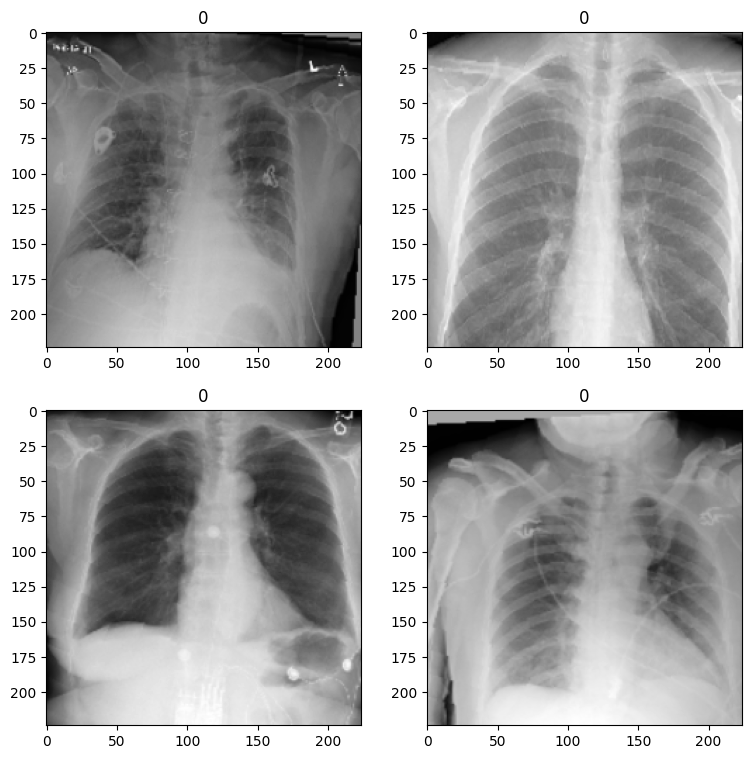

In [10]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
  for j in range(2):
    random_ind = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_ind]
    print(x_ray.shape)
    axis[i][j].imshow(x_ray[0], cmap="gray")
    axis[i][j].set_title(label)



In [11]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)


In [12]:
# torchvision.models.resnet18()

In [13]:
torchvision.models.efficientnet_v2_m()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
class PneumoniaModel(torch.nn.Module):
  def __init__(self):
    super(PneumoniaModel, self).__init__()
    self.model = torchvision.models.efficientnet_v2_m()  # Adjust this line based on actual import

        # Modify the input layer to accept 1 channel instead of 3
    original_first_conv = self.model.features[0][0]
    self.model.features[0][0] = torch.nn.Conv2d(1,
                                                original_first_conv.out_channels,
                                                kernel_size=original_first_conv.kernel_size,
                                                stride=original_first_conv.stride,
                                                padding=original_first_conv.padding,
                                                bias=False)

    # Modify the output layer for binary classification
    num_features = self.model.classifier[1].in_features  # Assuming the classifier has this structure
    self.model.classifier[1] = torch.nn.Linear(num_features, 1)

  def forward(self, x):
    return self.model(x)


In [15]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [16]:
model = PneumoniaModel().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
def calculate_accuracy(outputs, labels):
    # Convert outputs to predictions: 1 if output >= 0.5, 0 otherwise
    preds = outputs >= 0.5
    correct = (preds == labels.byte()).float()  # Convert to float for division
    accuracy = correct.sum() / len(correct)
    return accuracy

In [18]:
for epoch in range(20):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs.squeeze(), labels.float())  # Adjust the output shape if necessary
        accuracy = calculate_accuracy(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs.squeeze(), labels.float())
            accuracy = calculate_accuracy(outputs.squeeze(), labels)

            val_running_loss += loss.item()
            val_running_accuracy += accuracy.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

print('Finished Training')


  0%|          | 0/751 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_save_path = 'models/pneumonia_classification.pth'
torch.save(model.state_dict(), model_save_path)